# MODELOS PREDICTIVOS PARA SISTEMAS INTELIGENTES 

## Taller

El dataset que trabajaremos en el taller ("ProyectoSeminario.txt") Contiene 2.075.259 medidas entre Diciembre de 2016 y Noviembre de 2010 (47 meses), y contiene la siguiente información:


* globalactivepower: household global minute-averaged active power (in kilowatt)
* globalreactivepower: household global minute-averaged reactive power (in kilowatt)
* voltage: minute-averaged voltage (in volt)
* global_intensity: household global minute-averaged current intensity (in ampere)
* submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
* submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
* submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


Se requiere obtener dos modelos predictivos: Predicción en series de tiempo y Modelo de clasificación:

* Predicción en series de tiempo: se requiere un modelo que permita predecir la potencia activa global (globalactivepoweer) tomando las últimas 48 horas de registro, y que permita estimar la potencia para las 24 horas siguientes (Nota: submuestrear la serie de tiempo para que la base de tiempo sean horas). Para este modelo se espera que se realicen todas las operaciones necesarias: inspección inicial del dataset, limpieza de datos, submuestreo, filtrado, preparación del dataset, creación de la arquitectura del modelo, entrenamiento del modelo, evaluación del desempeño, y finalmente la predicción para 24 horas siguientes, dado un historico de 48 horas pasadas.



* Sistema de clasificación: se requiere un modelo que permita predecir si la potencia activa global es alta o baja (dadas las medidas de: Global_reactive_power, Voltage	Global_intensity, Sub_metering_1, Sub_metering_2	Sub_metering_3), según los siguientes umbrales:


   *   Potencia Activa Global Alta = consumo mayor a 0.8 KW
   *   Potencia Activa Global Baja = consumo menor que 0.8 KW

  Proponer un sistema de clasificación basado en: redes neuronales, bosques aleatorios y regresión logística. Para este modelo se espera que se realicen todas las operaciones necesarias: inspección inicial del dataset, limpieza de datos, preparación del dataset, creación de la arquitectura del modelo, entrenamiento del modelo, evaluación del desempeño, y finalmente la predicción de la potencia activa global dado un conjunto de datos independientes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dfdata = pd.read_table('datasets/ProyectoSeminario.txt',sep=';',low_memory=False)


## Limpieza de los datos


In [3]:
dfdata.count()

Date                     2075259
Time                     2075259
Global_active_power      2075259
Global_reactive_power    2075259
Voltage                  2075259
Global_intensity         2075259
Sub_metering_1           2075259
Sub_metering_2           2075259
Sub_metering_3           2049280
dtype: int64

In [4]:
dfdata.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [5]:
dfdata['Global_active_power'] = pd.to_numeric(dfdata.Global_active_power, errors='coerce')
dfdata['Global_reactive_power'] = pd.to_numeric(dfdata.Global_reactive_power, errors='coerce')
dfdata['Voltage'] = pd.to_numeric(dfdata.Voltage, errors='coerce')
dfdata['Global_intensity'] = pd.to_numeric(dfdata.Global_intensity, errors='coerce')
dfdata['Sub_metering_1'] = pd.to_numeric(dfdata.Sub_metering_1, errors='coerce')
dfdata['Sub_metering_2'] = pd.to_numeric(dfdata.Sub_metering_2, errors='coerce')


In [6]:
dfdata.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [7]:
# Verificar la cantidad de datos por cada columna
dfdata.count()

Date                     2075259
Time                     2075259
Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [8]:
# Verificar si hay datos nulos
dfdata.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

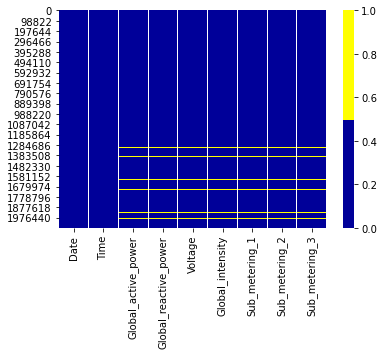

In [9]:
## Generar mapa de calor con seaborn para observar mejor los datos nulos
colours= ['#000099','#ffff00']
sns.heatmap(dfdata.isnull(),cmap=sns.color_palette(colours))
plt.show()

In [10]:
#Rellenar los datos de dataframe con los datos de propagacion hacia adelante-- rellena la fila de adelante con el valor anterior
dfdata.Global_active_power= dfdata.Global_active_power.fillna(method='ffill')
dfdata.Global_reactive_power= dfdata.Global_reactive_power.fillna(method='ffill')
dfdata.Voltage= dfdata.Voltage.fillna(method='ffill')
dfdata.Global_intensity= dfdata.Global_intensity.fillna(method='ffill')
dfdata.Sub_metering_1= dfdata.Sub_metering_1.fillna(method='ffill')
dfdata.Sub_metering_2= dfdata.Sub_metering_2.fillna(method='ffill')
dfdata.Sub_metering_3= dfdata.Sub_metering_3.fillna(method='ffill')


dfdata.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [11]:
dfdata.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [12]:
dfdata["date"] = dfdata["Date"] + " " + dfdata["Time"]

In [13]:
dfdata = dfdata.drop(labels=['Date','Time'],axis=1)

In [14]:
dfdata.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16/12/2006 17:28:00


In [15]:
##Especificar formato fecha Año(Y) Mes(m) Dia(d)
# enlace a formato ... https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

dfdata['date']=pd.to_datetime(dfdata['date'],format='%d/%m/%Y %H:%M:%S')

dfdata.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [16]:
##Ver que dia cayo cada fecha
dfdata['date'].dt.day_name()

0          Saturday
1          Saturday
2          Saturday
3          Saturday
4          Saturday
             ...   
2075254      Friday
2075255      Friday
2075256      Friday
2075257      Friday
2075258      Friday
Name: date, Length: 2075259, dtype: object

In [17]:
dfdata.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
std,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [18]:
dfdata.count()

Global_active_power      2075259
Global_reactive_power    2075259
Voltage                  2075259
Global_intensity         2075259
Sub_metering_1           2075259
Sub_metering_2           2075259
Sub_metering_3           2075259
date                     2075259
dtype: int64

In [19]:
#cambiar el indice del data frame por date
dfdata.set_index('date',inplace=True)

In [20]:
dfdata.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [21]:
dfdata.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
std,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Predicción en series de tiempo

In [23]:
# Eliminar los campos ...El predictor será para la variable globalactivepoweer
data_aux =dfdata.drop(labels=['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'],axis=1)

data_aux.head()


,Global_active_power
date,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [24]:
# Dividir datos entrenamiento y test
from sklearn.model_selection import train_test_split 

datatrain, datatest = train_test_split(data_aux, test_size = 0.2, random_state = 100, shuffle=False) 


In [26]:
datatrain.head()

,Global_active_power
date,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [27]:
datatest.head()

,Global_active_power
date,
2010-02-11 15:31:00,0.336
2010-02-11 15:32:00,0.334
2010-02-11 15:33:00,0.334
2010-02-11 15:34:00,0.336
2010-02-11 15:35:00,0.334


In [29]:
#Reemuestrear datos a horas y calcular promedio
datatrain= datatrain.resample('H').mean()
datatest= datatest.resample('H').mean()

datatest.head()

,Global_active_power
date,
2010-02-11 15:00:00,0.401172
2010-02-11 16:00:00,0.477733
2010-02-11 17:00:00,0.655267
2010-02-11 18:00:00,1.436367
2010-02-11 19:00:00,2.319900


In [30]:
from sklearn.preprocessing import MinMaxScaler

scalar =MinMaxScaler(feature_range=(-1,1))  ##Contiene la informacion del escalado
datatrain_arr= scalar.fit_transform(datatrain)  ##Escalar el datatrain entre -1 y 1

datatest_arr= scalar.fit_transform(datatest)
datatrain_arr

array([[ 0.27363246],
       [ 0.0900899 ],
       [ 0.01801177],
       ...,
       [-0.7677114 ],
       [-0.94353068],
       [-0.94038065]])

In [31]:
##Ventana
steps=48

##Listas vacias que van a ser llenadas con el dataset
xtrain=[]
ytrain=[]

for i in range(len(datatrain_arr)-steps):
    xtrain.append(datatrain_arr[i:i+steps])
    ytrain.append(datatrain_arr[i+steps])
    
#TEST

xtest=[]
ytest=[]

for i in range(len(datatest_arr)-steps):
    xtest.append(datatest_arr[i:i+steps])
    ytest.append(datatest_arr[i+steps])

In [32]:
#convertir a numpy array
xtrain= np.asanyarray(xtrain)
ytrain= np.asanyarray(ytrain)

#TEST
xtest= np.asanyarray(xtest)
ytest= np.asanyarray(ytest)

In [33]:
print('Xtrain: {} Ytrain: {} '.format(xtrain.shape,ytrain.shape))

##TEST
print('Xtest: {} Ytest: {} '.format(xtest.shape,ytest.shape))

Xtrain: (27623, 48, 1) Ytrain: (27623, 1) 
Xtest: (6871, 48, 1) Ytest: (6871, 1) 


In [34]:
##CREAR MODELO

from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

model =Sequential() #Crear modelo secuencial
model.add(LSTM(units=256,return_sequences=True, activation='relu', input_shape=(steps,1)))  # Agregar capas tipo LSTM con 256 neuronas
model.add(Dropout(0.2)) ##el 20% de esa capa se va a desconectar para evitar overfit
model.add(LSTM(units=128,return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=32,return_sequences=False, activation='relu'))  
model.add(Dropout(0.2))
model.add(Dense(128))  
model.add(Dense(64))
model.add(Dense(ytrain.shape[1]))

model.summary() #Verificar el modelo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 48, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                1

In [35]:
#Compilar el modelo funcion de error y optimizador
model.compile(loss='mse',optimizer='adam')

In [36]:
##Entrenar el modelo y mostrar historico
history = model.fit(xtrain, ytrain, epochs=100, validation_split=0.1, batch_size= 32, verbose= 1)

Epoch 1/100
777/777 [==============================] - 133s 166ms/step - loss: 1056.1747 - val_loss: 0.0749
Epoch 2/100
777/777 [==============================] - 134s 173ms/step - loss: 0.0712 - val_loss: 0.0744
Epoch 3/100
777/777 [==============================] - 139s 179ms/step - loss: 0.0677 - val_loss: 0.0655
Epoch 4/100
777/777 [==============================] - 136s 176ms/step - loss: 0.0590 - val_loss: 0.0523
Epoch 5/100
777/777 [==============================] - 140s 180ms/step - loss: 0.0452 - val_loss: 0.0392
Epoch 6/100
777/777 [==============================] - 140s 181ms/step - loss: 0.0412 - val_loss: 0.0382
Epoch 7/100
777/777 [==============================] - 138s 178ms/step - loss: 0.0394 - val_loss: 0.0373
Epoch 8/100
777/777 [==============================] - 138s 178ms/step - loss: 0.0386 - val_loss: 0.0401
Epoch 9/100
777/777 [==============================] - 137s 177ms/step - loss: 0.0379 - val_loss: 0.0361
Epoch 10/100
777/777 [==============================

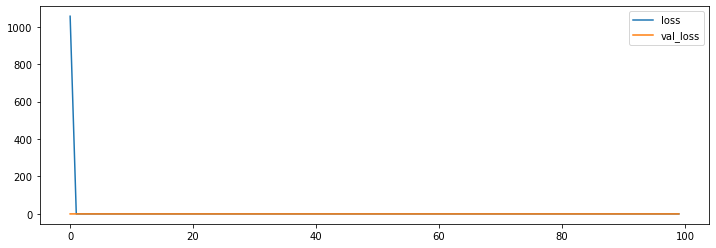

In [54]:
#Graficar Errores de entrenamiento y validacion
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [38]:
#Guardar modelo
model.save('ProyectoSeriesT.h5')

In [55]:
# Evaluar la predicción del modelo con el dataset de test 
from tensorflow.keras.models import load_model
model= load_model('ProyectoSeriesT.h5')

In [56]:
## PREDICCIONES DEL MODELO
ypred= model.predict(xtest)  #resultado de las predicciones
ypred= scalar.inverse_transform(ypred)  #hacer escala inversa de -1 y 1 a rango normal
ytest= scalar.inverse_transform(ytest)

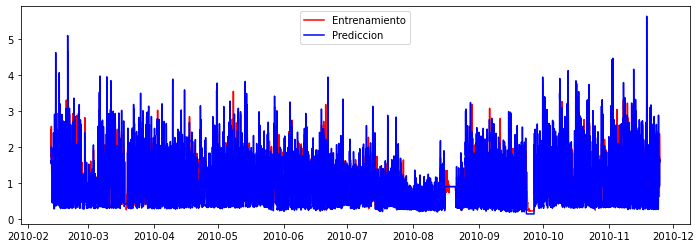

In [61]:
##Graficar prediccion y datos esperados 

plt.figure(figsize=(12, 4))
#plt.plot(datatrain.index[:-steps],scalar.inverse_transform(ytrain), 'y')  #DATOS ENTRENAMIENTO
plt.plot(datatest.index[:-steps],ypred, 'r')

plt.plot(datatest.index[:-steps],ytest, 'b')

plt.legend(['Entrenamiento','Prediccion','Esperado'])
plt.show()

In [62]:
##CAlcular error cuadratico medio
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest,ypred)

0.2664846909381377

In [63]:
xtest.shape

(6871, 48, 1)

In [64]:
##PREDiCCiON

xin= np.array([14,15,16,16.7,15.3,17,14.5,15.3,16.2,15.6,16.2,14.7,16.8,15.3,15.1,16.2,15.8,16,14,16,
              14,15,16,16.7,15.3,17,14.5,15.3,16.2,15.6,16.2,14.7,16.8,15.3,15.1,16.2,15.8,16,14,16,
              14,15,16,16.7,15.3,17,14.5,15.3])
xin=scalar.fit_transform(xin.reshape(-1,1))
xin=xin.reshape(1,48,1)

In [65]:
xin.shape

(1, 48, 1)

In [66]:
yout = model.predict(xin)
yout = scalar.inverse_transform(yout)
yout

array([[15.136055]], dtype=float32)

In [ ]:
##Para 24 horas

lst_output=[]
n_steps=100
i=0
while(i<24):